In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install torch torchvision torchaudio
# !pip install gensim

In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
#gloVe_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/word2vec.bin', binary=True)
def loadData(filePath):
  with open(filePath, "r") as f:
    data = json.load(f)
  texts = []
  labels = []
  for id in range(1, len(data)+1):
    texts.append(data[str(id)]["text"])
    labels.append(data[str(id)]["labels"])
  return texts, labels

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

def applyEmbedding(texts, glove_model):
    finList = []
    for text in texts:
        tempList = []
        for word in text.split():
            if word in glove_model:
                tempList.append(glove_model[word])
            else:
                tempList.append(np.random.rand(len(next(iter(glove_model.values())))))
        finList.append(tempList)
    return finList

trainTexts, trainLabels = loadData("/content/drive/MyDrive/NLP_ass2/train_processed_t2.json")
validationTexts, validationLabels = loadData("/content/drive/MyDrive/NLP_ass2/validation_processed_t2.json")
testTexts, testLabels = loadData("/content/drive/MyDrive/NLP_ass2/test_processed_t2.json")

glove_model = loadGloveModel("/content/drive/MyDrive/glove.6B.100d.txt")

embedded_trainTexts = applyEmbedding(trainTexts, glove_model)
embedded_validationTexts = applyEmbedding(validationTexts, glove_model)
embedded_testTexts = applyEmbedding(testTexts, glove_model)


print("The example of embedded training data is: ", embedded_trainTexts[0])

print("The example of embedded validation data is: ", embedded_validationTexts[0])
print("The example of embedded test data is: ", embedded_testTexts[0])
print("The example of trained labels is: ", trainLabels[0])
print("Embedding applied.")


Loading Glove Model
Done. 400000  words loaded!
The example of embedded training data is:  [array([0.61125247, 0.44826763, 0.72802558, 0.33647293, 0.55473841,
       0.34756433, 0.3241473 , 0.82068132, 0.95975888, 0.91608898,
       0.32499281, 0.78030755, 0.86984922, 0.81306559, 0.2760325 ,
       0.93649833, 0.62263978, 0.45238542, 0.85481557, 0.16063383,
       0.89658721, 0.34963483, 0.69250997, 0.45353578, 0.60004993,
       0.34418998, 0.95900692, 0.47795742, 0.68521531, 0.47821259,
       0.88608463, 0.11189677, 0.53975587, 0.32807692, 0.46902678,
       0.52813193, 0.57542287, 0.50994718, 0.94897323, 0.31880793,
       0.12595445, 0.66253767, 0.47838812, 0.35187878, 0.99218483,
       0.19350962, 0.62001691, 0.47544141, 0.53110463, 0.8461227 ,
       0.95987659, 0.7728122 , 0.91190436, 0.71033149, 0.88936068,
       0.6543883 , 0.99384642, 0.70806153, 0.57662585, 0.6604381 ,
       0.92340245, 0.64328266, 0.29747802, 0.14376485, 0.43457495,
       0.14429246, 0.81500825, 0.0855

In [ ]:
print(len(embedded_trainTexts[0][0]))
print(len(trainLabels[2]))

100
14


In [ ]:
for sent in range(len(trainLabels)):
  for label in range(len(trainLabels[sent])):
    if trainLabels[sent][label]=="B":
      trainLabels[sent][label] = 0
    elif trainLabels[sent][label]=="I":
      trainLabels[sent][label] = 1
    elif trainLabels[sent][label]=="O":
      trainLabels[sent][label] = 2

for sent in range(len(validationLabels)):
  for label in range(len(validationLabels[sent])):
    if validationLabels[sent][label]=="B":
      validationLabels[sent][label] = 0
    elif validationLabels[sent][label]=="I":
      validationLabels[sent][label] = 1
    elif validationLabels[sent][label]=="O":
      validationLabels[sent][label] = 2

for sent in range(len(testLabels)):
  for label in range(len(testLabels[sent])):
    if testLabels[sent][label]=="B":
      testLabels[sent][label] = 0
    elif testLabels[sent][label]=="I":
      testLabels[sent][label] = 1
    elif testLabels[sent][label]=="O":
      testLabels[sent][label] = 2


embedded_trainTensor = []
for senVect in embedded_trainTexts:
  embedded_trainTensor.append(torch.tensor(senVect))
embedded_validationTensor = []
for senVect in embedded_validationTexts:
  embedded_validationTensor.append(torch.tensor(senVect))
embedded_testTensor = []
for senVect in embedded_testTexts:
  embedded_testTensor.append(torch.tensor(senVect))
label_trainTensor = []
for label in trainLabels:
  print(label)
  break
for label in trainLabels:
  label_trainTensor.append(torch.tensor(label))
label_validationTensor = []
for label in validationLabels:
  label_validationTensor.append(torch.tensor(label))
label_testTensor = []
for label in testLabels:
  label_testTensor.append(torch.tensor(label))

print(type(label_testTensor[0][0]))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2]
<class 'torch.Tensor'>


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, embedded_data, labels):
        self.embedded_data = embedded_data
        self.labels = labels
        self.max_length = 469

    def __len__(self):
        return len(self.embedded_data)

    def __getitem__(self, idx):
        embedded_sequence = self.embedded_data[idx]
        #print(type(embedded_sequence))
        labels = self.labels[idx]
        lent=len(labels)
        padded_sequence = []
        padded_labels=[]
        if(lent<=self.max_length):
          padded_sequence = embedded_sequence.tolist() + [[0] * 100 for _ in range(self.max_length - lent)]
          padded_labels=labels.tolist()+[-100]*(self.max_length - lent)

        return torch.tensor(padded_sequence).float(), torch.tensor(padded_labels).float()

    # def __getitem__(self, idx):
    #     return torch.tensor(self.embedded_data[idx]), torch.tensor(self.labels[idx])


trainDataset = CustomDataset(embedded_trainTensor, label_trainTensor)
validationDataset = CustomDataset(embedded_validationTensor, label_validationTensor)
testDataset = CustomDataset(embedded_testTensor, label_testTensor)

import torch
import torch.nn.utils.rnn as rnn_utils

# Function to pad sequences and labels in a batch
# def pad_collate(batch):
#     sequences, labels = zip(*batch)
#     sequences_padded = rnn_utils.pad_sequence(sequences, batch_first=True, padding_value=0)

#     max_seq_length = sequences_padded.size(1)
#     padded_labels = []
#     for label in labels:
#         padded_label = torch.full((max_seq_length,), -100)
#         padded_label[:len(label)] = label
#         padded_labels.append(padded_label)

#     # Stack padded labels into a single tensor
#     labels_padded = torch.stack(padded_labels)
#     sequences_padded = sequences_padded.float()
#     labels_padded = labels_padded.float()
#     return sequences_padded, labels_padded


trainLoader = DataLoader(trainDataset, batch_size = 32, shuffle = True)
validationLoader = DataLoader(validationDataset, batch_size = 32, shuffle = False)
testLoader = DataLoader(testDataset, batch_size = 32, shuffle = False)
print(type(trainLoader))


<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    final_predictions = []
    final_labels = []
    with torch.no_grad():
        for seq, label in test_loader:
          outputs = model(seq)
          for k in range(len(label.tolist())):
            i=label[k]
            j=outputs[k]
            a=i.tolist().index(-100)
            b=i.tolist()[:a]
            d=torch.tensor(j.tolist()[:a])
            predicted_labels = (torch.argmax(d, dim=1)).tolist()
            final_predictions=final_predictions+predicted_labels
            final_labels=final_labels+b
            # print(b)
            # print(d)

    print(final_predictions)
    print(final_labels)


    accuracy = accuracy_score(final_labels, final_predictions)
    macro_f1 = f1_score(final_labels, final_predictions, average='macro')
    return accuracy, macro_f1

In [ ]:
import torch.nn.functional as F
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        #h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x)
        #out = self.fc(out[:, -1, :])
        out = self.fc(out)
        return out

    def custom_loss(self, predicted_probs, target_labels):
        """
        Custom loss function that computes the cross-entropy loss
        given predicted probabilities and target labels.
        """
        # Apply masking to handle variable-length sequences with padding
        mask = (target_labels != -100).float()

        # Compute cross-entropy loss
        loss = F.cross_entropy(predicted_probs.permute(0, 2, 1), target_labels.to(torch.long), reduction='none')
        # Apply masking to ignore padded elements
        masked_loss = (loss * mask).sum(dim=1).mean()

        return masked_loss

def macro_f1_score(predictions, labels):
    predictions = predictions.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, predictions, average='macro')

def trainModel(model, trainLoader, validationLoader, criterion, optimizer, epochCount):
  trainLoss = []
  valLoss = []
  trainF1score = []
  valF1score = []
  va = 0
  model.train()
  for epoch in range(epochCount):
    print(epoch)
    curTrainLoss = 0.0
    curTrainPredictions = []
    curTrainLabels = []

    for seq,label in trainLoader:
      #print(seq.shape)
      #print(label.shape)
      optimizer.zero_grad()
      outputs = model(seq)
      # print(type(outputs), type(label))
      #print(outputs.shape)
      # print(label.shape)

      loss = model.custom_loss(outputs, label)
      # loss.requires_grad = True
      loss.backward()
      optimizer.step()
      curTrainLoss = curTrainLoss + loss.item()

      curTrainPredictions.extend(outputs.argmax(dim=1).cpu().numpy())
      curTrainLabels.extend(label.argmax(dim=1).cpu().numpy())

    trainLoss.append(curTrainLoss/len(trainLoader))
    #trainF1score.append(macro_f1_score(torch.tensor(curTrainPredictions), torch.tensor(curTrainLabels)))
    acc,f1=evaluate_model(model,trainLoader)
    trainF1score.append(f1)
    model.eval()
    print(curTrainLoss)
    curValLoss = 0.0
    curValPredictions = []
    curValLabels = []
    with torch.no_grad():
      for seq, label in validationLoader:
        outputs = model(seq)
        loss = model.custom_loss(outputs, label)
        curValLoss = curValLoss + loss.item()
        curValPredictions.extend(outputs.argmax(dim=1).cpu().numpy())
        curValLabels.extend(label.argmax(dim=1).cpu().numpy())

    valLoss.append(curValLoss/len(validationLoader))
    #valF1score.append(macro_f1_score(torch.tensor(curValPredictions), torch.tensor(curValLabels)))
    acc,f1=evaluate_model(model,validationLoader)
    valF1score.append(f1)

  return trainLoss, trainF1score, valLoss, valF1score


# def evaluateModel(model, testLoader):
#   model.eval()
#   finalPredictions = []
#   finalLabels = []

#   with torch.no_grad():
#     for seq, label in testLoader:
#       outputs = model(seq)
#       finalPredictions.extend(outputs.argmax(dim=1).cpu().numpy())
#       finalLabels.extend(label.argmax(dim=1).cpu().numpy())

#   accuracy = accuracy_score(finalLabels, finalPredictions)
#   macro_f1 = f1_score(finalLabels, finalPredictions, average='macro')
#   return accuracy, macro_f1


inputDim = 100 # Based on size of word2vec embedding
hiddenDim = 128 # Randomly chosen
outputDim = 3 # No of labels
numEpochs = 20
learningRate = 0.02

model = VanillaRNN(inputDim, hiddenDim, outputDim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learningRate)

finalTrainLoss, finalTrainF1score, finalValLoss, finalValF1score = trainModel(model, trainLoader, validationLoader, criterion, optimizer, numEpochs)
# finalAccuracy, macroF1score = evaluateModel(model, testLoader)

# print("The accuracy of the model is: ", finalAccuracy)
# print("The Macro-F1 score obtained is: ", macroF1score)




0
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2

In [ ]:
finalAccuracy, macroF1score = evaluate_model(model, testLoader)

print("The accuracy of the model is: ", finalAccuracy)
print("The Macro-F1 score obtained is: ", macroF1score)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
word2vecpath='/content/drive/MyDrive/t2_glove_RNN.pth'
torch.save(model.state_dict(), word2vecpath)

In [ ]:
word2vecmidel = torch.load(word2vecpath)

last_model = VanillaRNN(100,128,3)
last_model.load_state_dict(word2vecmidel)


In [ ]:
import matplotlib.pyplot as plt

def plotloss(losses,name):
  epochs = range(1, len(losses) + 1)

  plt.plot(epochs, losses, marker='o', color='brown', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} Loss')
  plt.title(f'{name} Loss vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_f1(f1,name):
  epochs = range(1, len(f1) + 1)

  plt.plot(epochs, f1, marker='o', color='brown', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} F1')
  plt.title(f'{name} F1 vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

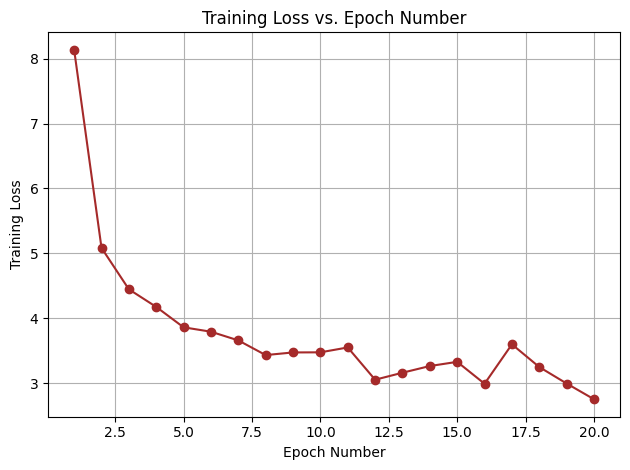

In [ ]:
plotloss(finalTrainLoss,"Training")

In [ ]:
print("Train f1 score",finalTrainF1score)

Train f1 score [0.4528092844440879, 0.3610266218083605, 0.6186378618369903, 0.6975740390842958, 0.6930750380937233, 0.6340977231786752, 0.7554937379988762, 0.7331874403220903, 0.7715801713390661, 0.7539902215202194, 0.741909659270522, 0.7737308897929559, 0.731772777944498, 0.7161065665707863, 0.7663429858190681, 0.7839624549714553, 0.7625657951245569, 0.7912384449199253, 0.7611142213358325, 0.8178085701279114]


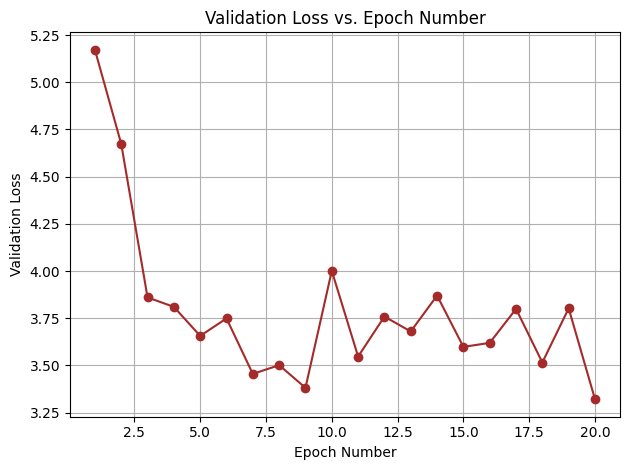

In [ ]:
plotloss(finalValLoss,"Validation")

In [ ]:
print("Validation f1 score",finalValF1score)

Validation f1 score [0.4683007510081063, 0.38684905917195866, 0.6612606712150458, 0.7034542995049341, 0.6919491332606, 0.6395731346910339, 0.724585827664315, 0.726051747827939, 0.7362150574011735, 0.7236024844720497, 0.6955683754591501, 0.7296192502262139, 0.6782071731713515, 0.6749580850937718, 0.6923653796965713, 0.7344945130668218, 0.726890965036138, 0.7203736504798021, 0.6836048759380856, 0.7519379740581833]


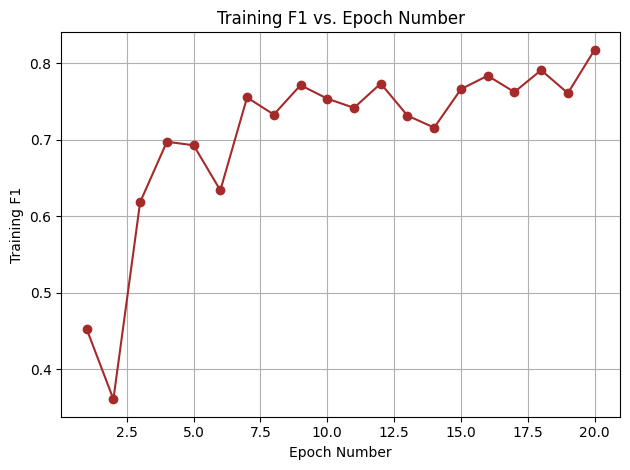

In [ ]:
plot_f1(finalTrainF1score,"Training")

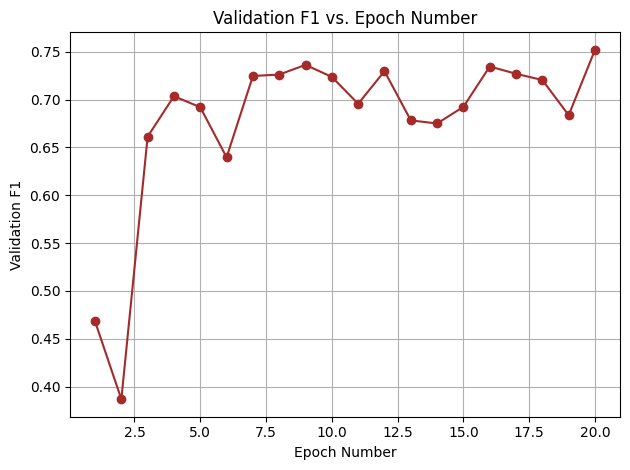

In [ ]:
plot_f1(finalValF1score,"Validation")